Генерация слоя городских кварталов с помощью blocksnet

In [27]:
!pip install blocksnet  -q
!pip install blocksnet ipykernel mapclassify -qq


In [28]:
import geopandas as gpd
import osmnx as ox
import pandas as pd
import os


In [ ]:
data_path = "../data/scenario 1 - data"
results_path = "../results/scenario 1 - results"

<h3>Загрузка границ, дорог, построение полигонов</h3>

<Axes: >

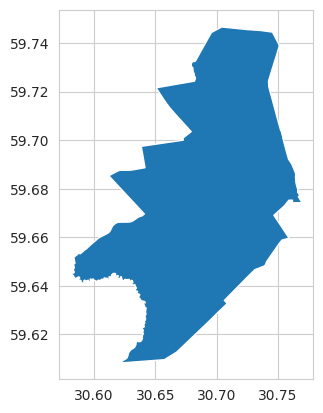

In [30]:
boundary = gpd.read_file(os.path.join(data_path,'boundary.geojson'))
boundary.plot()

<Axes: >

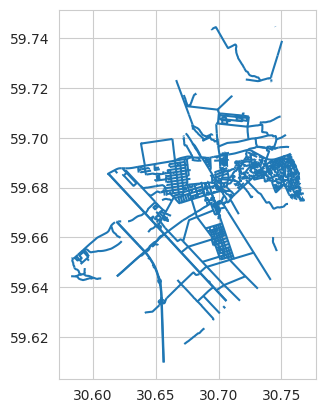

In [31]:
roads = gpd.read_file(os.path.join(data_path,'roads.geojson'))
roads.plot()

In [32]:
local_crs = boundary.estimate_utm_crs()
local_crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
boundary = boundary.reset_index()[['geometry']].to_crs(local_crs)
roads = roads.reset_index()[['geometry']].to_crs(local_crs)

In [34]:
import momepy

roads = roads[roads.geom_type.isin(['LineString', 'MultiLineString'])]
GAP_TOLERANCE = 1
def _get_roads(roads):
    merged = roads.unary_union
    if merged.geom_type == 'MultiLineString':
        roads = gpd.GeoDataFrame(geometry=list(merged.geoms), crs=roads.crs)
    else:
        roads = gpd.GeoDataFrame(geometry=[merged], crs=roads.crs)
    roads = roads.explode(index_parts=False).reset_index(drop=True)
    roads.geometry = momepy.close_gaps(roads, GAP_TOLERANCE)
    roads = roads[roads.geom_type.isin(['LineString'])]
    return roads

roads = _get_roads(roads)
roads

geometry
0     LINESTRING (365578.066 6618818.811, 365585.179...
1     LINESTRING (367700.433 6616376.542, 367698.837...
2     LINESTRING (368477.180 6617657.195, 368413.340...
3     LINESTRING (368413.340 6617725.792, 368382.078...
4     LINESTRING (372228.902 6619496.063, 372224.703...
...                                                 ...
1942  LINESTRING (370603.979 6615698.772, 370603.979...
1943  LINESTRING (370603.979 6615698.772, 370793.859...
1944  LINESTRING (370643.020 6615571.019, 370832.162...
1945  LINESTRING (370684.048 6615436.682, 370684.059...
1946  LINESTRING (370684.059 6615436.685, 370873.224...

[1947 rows x 1 columns]

In [35]:
from blocksnet import BlocksGenerator

bg = BlocksGenerator(boundary, roads, None, None)

2024-12-24 18:13:49.806 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:99 - Check boundaries schema
2024-12-24 18:13:49.825 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:103 - Check roads schema
2024-12-24 18:13:49.858 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:109 - Check railways schema
2024-12-24 18:13:49.868 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:115 - Check water schema
2024-12-24 18:13:49.883 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:124 - Exclude water objects
/usr/local/lib/python3.10/dist-packages/blocksnet/preprocessing/blocks_generator.py:125: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  line_water = water[water.geom_type != "LineString"].unary_union


In [36]:
blocks = bg.run()
blocks

2024-12-24 18:13:49.933 | INFO     | blocksnet.preprocessing.blocks_generator:run:161 - Generating blocks
2024-12-24 18:13:49.970 | INFO     | blocksnet.preprocessing.blocks_generator:run:170 - Setting up enclosures
2024-12-24 18:13:50.131 | INFO     | blocksnet.preprocessing.blocks_generator:run:174 - Filling holes
2024-12-24 18:13:50.206 | INFO     | blocksnet.preprocessing.blocks_generator:run:178 - Dropping overlapping blocks
2024-12-24 18:13:50.434 | INFO     | blocksnet.preprocessing.blocks_generator:run:192 - Calculating blocks area
2024-12-24 18:13:50.449 | INFO     | blocksnet.preprocessing.blocks_generator:run:199 - Blocks generated


geometry
0    POLYGON ((365578.066 6618818.811, 365585.179 6...
1    POLYGON ((365585.179 6618823.682, 365578.066 6...
2    POLYGON ((367700.433 6616376.542, 367698.837 6...
3    POLYGON ((367699.528 6616357.359, 367698.808 6...
4    POLYGON ((368477.180 6617657.195, 368413.340 6...
..                                                 ...
415  POLYGON ((370064.571 6616115.069, 370157.744 6...
416  POLYGON ((370157.744 6616139.801, 370253.091 6...
417  POLYGON ((370253.091 6616165.057, 370346.989 6...
418  POLYGON ((370346.989 6616189.955, 370445.864 6...
419  POLYGON ((370445.864 6616216.172, 370540.495 6...

[420 rows x 1 columns]

<Axes: >

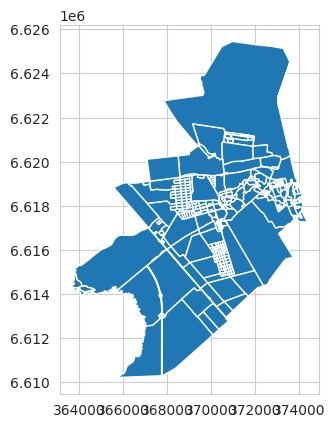

In [37]:
blocks.plot()

In [38]:
blocks.to_file(os.path.join(results_path,'blocks_blocksnet_1.geojson'))

### Свои дороги

In [39]:
CRS = 32636
SPEED_M_MIN = 1000

import networkx as nx

def _roads_to_graph(roads):
    graph = momepy.gdf_to_nx(roads)
    graph.graph['crs'] = roads.crs.to_epsg()
    graph = nx.DiGraph(graph)
    for _, _, data in graph.edges(data=True):
        geometry = data['geometry']
        data['time_min'] = geometry.length / SPEED_M_MIN
        # data['weight'] = data['mm_len'] / 1000 / 1000
        # data['length_meter'] = data['mm_len'] / 1000
    for n, data in graph.nodes(data=True):
        graph.nodes[n]['x'] = n[0]  # Assign X coordinate to node
        graph.nodes[n]['y'] = n[1]

    return graph

roads_G = _roads_to_graph(roads)
roads_G

In [40]:
from blocksnet import AccessibilityProcessor
AccessibilityProcessor._fix_graph(roads_G)

In [41]:
from blocksnet import AccessibilityProcessor

ap = AccessibilityProcessor(blocks)
acc_mx = ap.get_accessibility_matrix(roads_G)
acc_mx.head() # вывод первых 5 строк полученной матрицы

0         1         2         3         4         5         6    \
0  0.000000  1.937500  2.962891  3.136719  4.253906  4.492188  7.527344   
1  1.937500  0.000000  4.308594  4.472656  2.791016  3.458984  5.609375   
2  2.962891  4.308594  0.000000  0.175293  1.666992  1.792969  6.339844   
3  3.136719  4.472656  0.175293  0.000000  1.831055  1.957031  6.503906   
4  4.253906  2.791016  1.666992  1.831055  0.000000  0.819336  5.011719   

        7         8         9    ...       410       411       412       413  \
0  7.738281  7.386719  7.691406  ...  6.367188  6.562500  6.660156  6.562500   
1  5.820312  5.468750  5.773438  ...  5.746094  5.945312  5.851562  5.945312   
2  6.269531  6.011719  5.683594  ...  3.404297  3.601562  3.699219  3.601562   
3  6.433594  6.175781  5.847656  ...  3.228516  3.425781  3.523438  3.425781   
4  4.941406  4.683594  4.355469  ...  3.300781  3.500000  3.402344  3.500000   

        414       415       416       417       418       419  
0  6.660156  6.335938  6.433594  6.531250  6.691406  6.734375  
1  5.851562  5.402344  5.500000  5.597656  5.757812  5.796875  
2  3.699219  3.375000  3.472656  3.570312  3.728516  3.769531  
3  3.523438  3.199219  3.296875  3.394531  3.554688  3.595703  
4  3.402344  2.953125  3.052734  3.150391  3.308594  3.349609  

[5 rows x 420 columns]

In [42]:
from blocksnet.models import City
from blocksnet import Accessibility, Connectivity

blocks['land_use'] = None

city = City(
    blocks=blocks,
    acc_mx=acc_mx
)

connectivity = Connectivity(city_model=city)
connectivity_result = connectivity.calculate()
connectivity_result

geometry  connectivity
id                                                                  
0    POLYGON ((365578.066 6618818.811, 365585.179 6...      6.359375
1    POLYGON ((365585.179 6618823.682, 365578.066 6...      5.199219
2    POLYGON ((367700.433 6616376.542, 367698.837 6...      3.605469
3    POLYGON ((367699.528 6616357.359, 367698.808 6...      3.531250
4    POLYGON ((368477.180 6617657.195, 368413.340 6...      3.167969
..                                                 ...           ...
415  POLYGON ((370064.571 6616115.069, 370157.744 6...      3.226562
416  POLYGON ((370157.744 6616139.801, 370253.091 6...      3.308594
417  POLYGON ((370253.091 6616165.057, 370346.989 6...      3.292969
418  POLYGON ((370346.989 6616189.955, 370445.864 6...      3.408203
419  POLYGON ((370445.864 6616216.172, 370540.495 6...      3.347656

[420 rows x 2 columns]

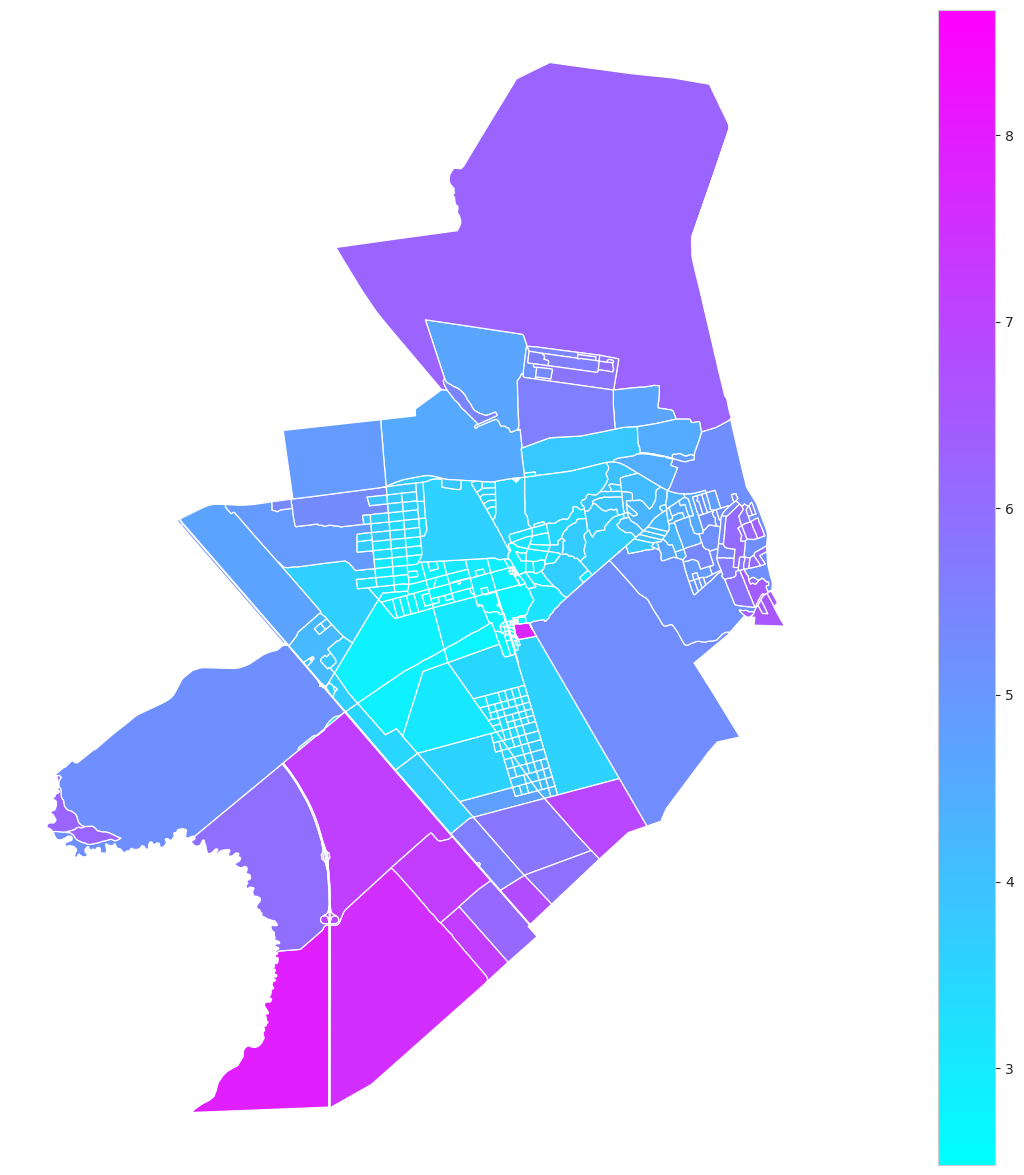

In [43]:
Connectivity.plot(connectivity_result, linewidth=0.9, figsize=(30,15))

In [44]:
import os
acc_mx.to_pickle(os.path.join(results_path,'acc_mx_1.pickle'))
city.to_pickle(os.path.join(results_path,'city_model_scenario 1.pickle'))

----

###Загрузка зданий

In [26]:
buildings = gpd.read_file(os.path.join(data_path,'buildings.geojson'))
buildings.explore()

In [45]:
buildings = buildings.to_crs(local_crs) # переводим здания в локальную систему координат
buildings.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [46]:
buildings

population building:levels  is_living      type  id  living_area  \
0            139               1          1      None NaN      12464.0   
1            173               1          1      None NaN      15429.0   
2            197               1          1      None NaN      17636.0   
3             90               1          1      None NaN       8050.0   
4            123               1          1      None NaN      10948.0   
...          ...             ...        ...       ...  ..          ...   
4816           0               1          0  building NaN          NaN   
4817           0               1          1  building NaN          NaN   
4818           0               1          1  building NaN          NaN   
4819           0               1          1  building NaN          NaN   
4820           0               1          1  building NaN          NaN   

      build_floor_area     building  \
0                12464  residential   
1                15429  residential   
2                17636  residential   
3                 8050  residential   
4                10948  residential   
...                ...          ...   
4816               526         None   
4817               106  residential   
4818               106  residential   
4819               103  residential   
4820                47  residential   

                                               geometry  
0     MULTIPOLYGON (((370784.561 6614885.336, 370698...  
1     MULTIPOLYGON (((370698.434 6615007.925, 370784...  
2     MULTIPOLYGON (((370698.434 6615007.925, 370618...  
3     MULTIPOLYGON (((370618.534 6615121.652, 370698...  
4     MULTIPOLYGON (((370618.534 6615121.652, 370529...  
...                                                 ...  
4816  MULTIPOLYGON (((371083.463 6616832.478, 371105...  
4817  MULTIPOLYGON (((370660.184 6617353.896, 370660...  
4818  MULTIPOLYGON (((370646.427 6617582.335, 370651...  
4819  MULTIPOLYGON (((370591.537 6617578.189, 370596...  
4820  MULTIPOLYGON (((367248.292 6618852.769, 367248...  

[4821 rows x 9 columns]

In [47]:
buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]
buildings.head()

population building:levels  is_living  type  id  living_area  \
0         139               1          1  None NaN      12464.0   
1         173               1          1  None NaN      15429.0   
2         197               1          1  None NaN      17636.0   
3          90               1          1  None NaN       8050.0   
4         123               1          1  None NaN      10948.0   

   build_floor_area     building  \
0             12464  residential   
1             15429  residential   
2             17636  residential   
3              8050  residential   
4             10948  residential   

                                            geometry  
0  MULTIPOLYGON (((370784.561 6614885.336, 370698...  
1  MULTIPOLYGON (((370698.434 6615007.925, 370784...  
2  MULTIPOLYGON (((370698.434 6615007.925, 370618...  
3  MULTIPOLYGON (((370618.534 6615121.652, 370698...  
4  MULTIPOLYGON (((370618.534 6615121.652, 370529...

In [48]:
# Сброс индекса, чтобы превратить индексы в обычные столбцы
buildings = buildings.reset_index(drop=True)
# Проверяем результат
buildings.head()

population building:levels  is_living  type  id  living_area  \
0         139               1          1  None NaN      12464.0   
1         173               1          1  None NaN      15429.0   
2         197               1          1  None NaN      17636.0   
3          90               1          1  None NaN       8050.0   
4         123               1          1  None NaN      10948.0   

   build_floor_area     building  \
0             12464  residential   
1             15429  residential   
2             17636  residential   
3              8050  residential   
4             10948  residential   

                                            geometry  
0  MULTIPOLYGON (((370784.561 6614885.336, 370698...  
1  MULTIPOLYGON (((370698.434 6615007.925, 370784...  
2  MULTIPOLYGON (((370698.434 6615007.925, 370618...  
3  MULTIPOLYGON (((370618.534 6615121.652, 370698...  
4  MULTIPOLYGON (((370618.534 6615121.652, 370529...

In [49]:
# Преобразуем столбец 'building:levels' в числовой тип, ошибки будут заменены на NaN
buildings['building:levels'] = pd.to_numeric(buildings['building:levels'], errors='coerce')

# Заполним пропущенные значения (NaN) нулями или другими подходящими значениями
buildings = buildings.fillna(0)

# Добавляем или преобразуем необходимые атрибуты

# 1. Количество этажей (number_of_floors)
buildings['number_of_floors'] = buildings.apply(
    lambda x: x['building:levels'] if x['building:levels'] > 1 else 1,
    axis=1
)

# 2. Площадь застройки (footprint_area) - как площадь геометрии (основание здания)
buildings['footprint_area'] = buildings.geometry.area

# 3. Общая площадь всех этажей (build_floor_area) - footprint_area * number_of_floors
buildings['build_floor_area'] = buildings['footprint_area'] * buildings['number_of_floors']

# 4. Жилая площадь (living_area) и нежилая площадь (non_living_area)
# Жилая площадь будет рассчитываться только для жилых зданий
residential_tags = ['residential', 'house', 'apartments', 'detached', 'terrace', 'dormitory', 'yes']
buildings['living_area'] = buildings.apply(
    lambda x: 0.8 * x['build_floor_area'] if x['building'] in residential_tags else 0,
    axis=1
)

# Нежилая площадь будет 20% от общей площади этажей
buildings['non_living_area'] = buildings['build_floor_area'] - buildings['living_area']

# 5. Население (population) - для жилых зданий
buildings['population'] = buildings.apply(
    lambda x: 48 * x['number_of_floors'] if x['building'] in residential_tags else 0,
    axis=1
)

# Теперь удалим все остальные столбцы, кроме 'geometry', 'build_floor_area', 'living_area', 'non_living_area',
# 'footprint_area', 'number_of_floors', 'population'
buildings = buildings[['geometry', 'build_floor_area', 'living_area', 'non_living_area',
                       'footprint_area', 'number_of_floors', 'population']]

# Проверим результат
buildings


geometry  build_floor_area  \
0     MULTIPOLYGON (((370784.561 6614885.336, 370698...      12458.692388   
1     MULTIPOLYGON (((370698.434 6615007.925, 370784...      15423.437949   
2     MULTIPOLYGON (((370698.434 6615007.925, 370618...      17628.785193   
3     MULTIPOLYGON (((370618.534 6615121.652, 370698...       8046.384657   
4     MULTIPOLYGON (((370618.534 6615121.652, 370529...      10944.039281   
...                                                 ...               ...   
4816  MULTIPOLYGON (((371083.463 6616832.478, 371105...        525.565495   
4817  MULTIPOLYGON (((370660.184 6617353.896, 370660...        105.650230   
4818  MULTIPOLYGON (((370646.427 6617582.335, 370651...        106.014300   
4819  MULTIPOLYGON (((370591.537 6617578.189, 370596...        103.229590   
4820  MULTIPOLYGON (((367248.292 6618852.769, 367248...         47.247866   

       living_area  non_living_area  footprint_area  number_of_floors  \
0      9966.953910      2491.738478    12458.692388                 1   
1     12338.750359      3084.687590    15423.437949                 1   
2     14103.028154      3525.757039    17628.785193                 1   
3      6437.107726      1609.276931     8046.384657                 1   
4      8755.231425      2188.807856    10944.039281                 1   
...            ...              ...             ...               ...   
4816      0.000000       525.565495      525.565495                 1   
4817     84.520184        21.130046      105.650230                 1   
4818     84.811440        21.202860      106.014300                 1   
4819     82.583672        20.645918      103.229590                 1   
4820     37.798293         9.449573       47.247866                 1   

      population  
0             48  
1             48  
2             48  
3             48  
4             48  
...          ...  
4816           0  
4817          48  
4818          48  
4819          48  
4820          48  

[4821 rows x 7 columns]

In [50]:
city.update_buildings(buildings)

2024-12-24 18:13:56.213 | INFO     | blocksnet.models.city:update_buildings:1237 - Removing existing blocks from the model
2024-12-24 18:13:56.231 | INFO     | blocksnet.models.city:update_buildings:1241 - Joining buildings and blocks
Update blocks buildings: 100%|██████████| 284/284 [00:03<00:00, 76.47it/s] 


Empty GeoDataFrame
Columns: [geometry, build_floor_area, living_area, non_living_area, footprint_area, number_of_floors, population]
Index: []

In [51]:
city.to_pickle(os.path.join('city_model.pickle'))

<Axes: >

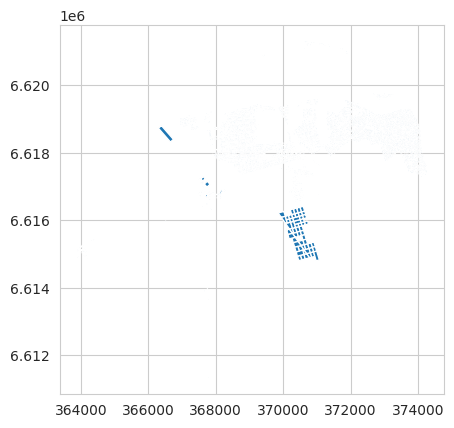

In [52]:
city.get_buildings_gdf().plot()

---------

###Загрузка сервисов

In [53]:
import os
import geopandas as gpd
from shapely.geometry import Point
from blocksnet import ServiceType

directory = os.fsencode(f"{data_path}/servises/")
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".geojson"):
        service_name = filename.removesuffix(".geojson")
        print(f"Adding service {service_name}")
        service_gdf = gpd.read_file(f"{data_path}/servises/" + filename)
        service_gdf.to_crs(local_crs, inplace=True)
        service = service_gdf[["geometry"]]
        try:
          city.update_services(service_name, service)
        except:
          continue
    else:
        continue

Adding service school
Adding service bus_station
Adding service supermarket
Adding service kindergarten


In [54]:
services_gdf = city.get_services_gdf()
services_gdf

geometry  block_id  service_type  capacity   area  \
0   POINT (367125.658 6619108.228)         1   bus_station        70  150.0   
1   POINT (372335.322 6619423.558)         7   bus_station        70  150.0   
2   POINT (373175.428 6619226.282)        25   bus_station        70  150.0   
3   POINT (373723.101 6619393.035)        26   bus_station        70  150.0   
4   POINT (373677.597 6619394.496)        26   bus_station        70  150.0   
..                             ...       ...           ...       ...    ...   
62  POINT (370406.254 6615289.835)       403   bus_station        70  150.0   
63  POINT (370655.680 6615355.302)       406  kindergarten        80  180.0   
64  POINT (370794.870 6615246.651)       407   supermarket       200  100.0   
65  POINT (370155.844 6615978.702)       408   supermarket       200  100.0   
66  POINT (370126.280 6616077.412)       415   supermarket       200  100.0   

    is_integrated  building_id  
0           False          NaN  
1           False          NaN  
2           False          NaN  
3           False          NaN  
4           False          NaN  
..            ...          ...  
62           True          7.0  
63           True         43.0  
64           True         44.0  
65           True         45.0  
66           True         51.0  

[67 rows x 7 columns]

---------------

###Подсчёт обеспеченности

Bus stantion

2024-12-24 18:14:07.393 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 60 : 250x34
2024-12-24 18:14:09.059 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-12-24 18:14:10.035 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-12-24 18:14:10.749 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


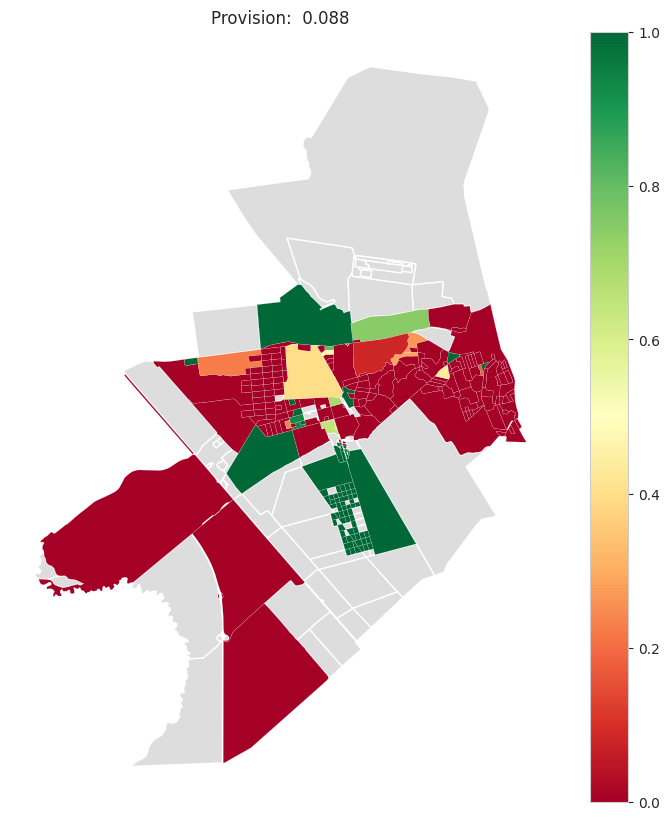

In [55]:
from blocksnet import Provision, ProvisionMethod
service_type = 'bus_station'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)
prov.plot(prov_res)

2024-12-24 18:17:41.659 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 7 : 250x6
2024-12-24 18:17:41.842 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-12-24 18:17:41.946 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-12-24 18:17:42.126 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


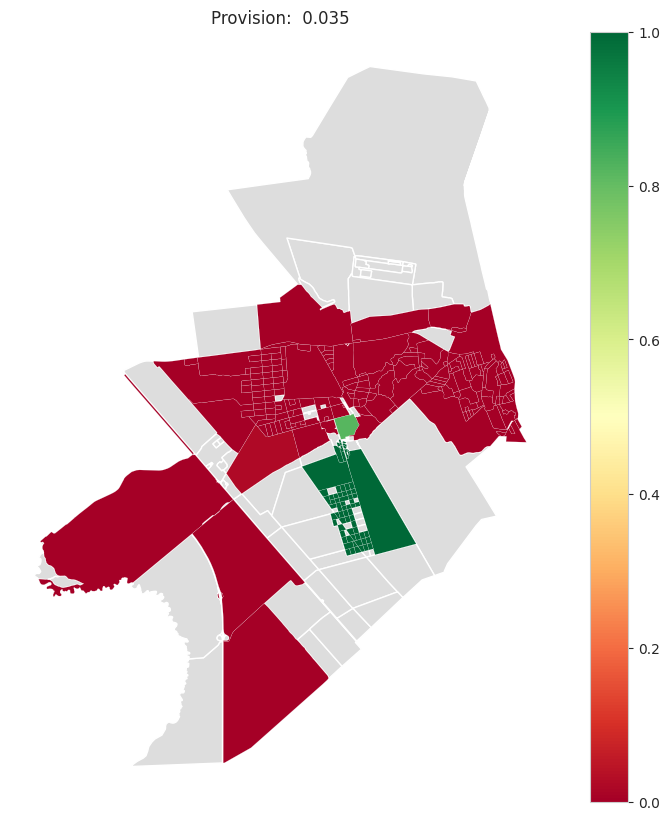

In [65]:
from blocksnet import Provision, ProvisionMethod
service_type = 'kindergarten'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)
prov.plot(prov_res)

2024-12-24 18:18:11.604 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 15 : 250x3
2024-12-24 18:18:11.661 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-12-24 18:18:11.700 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-12-24 18:18:11.780 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


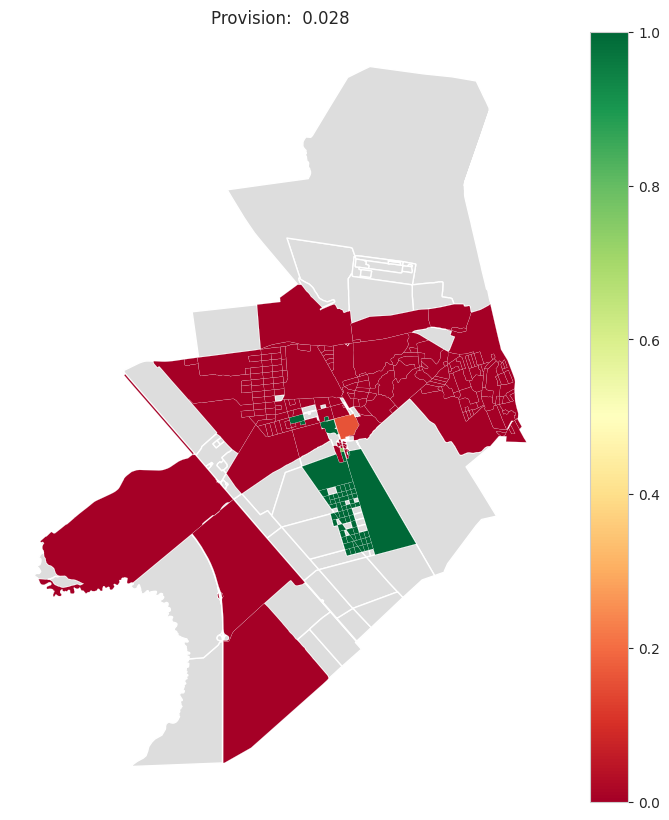

In [66]:
from blocksnet import Provision, ProvisionMethod
service_type = 'school'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)
prov.plot(prov_res)

2024-12-24 18:18:34.531 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 15 : 250x16
2024-12-24 18:18:34.786 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-12-24 18:18:34.937 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-12-24 18:18:35.081 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


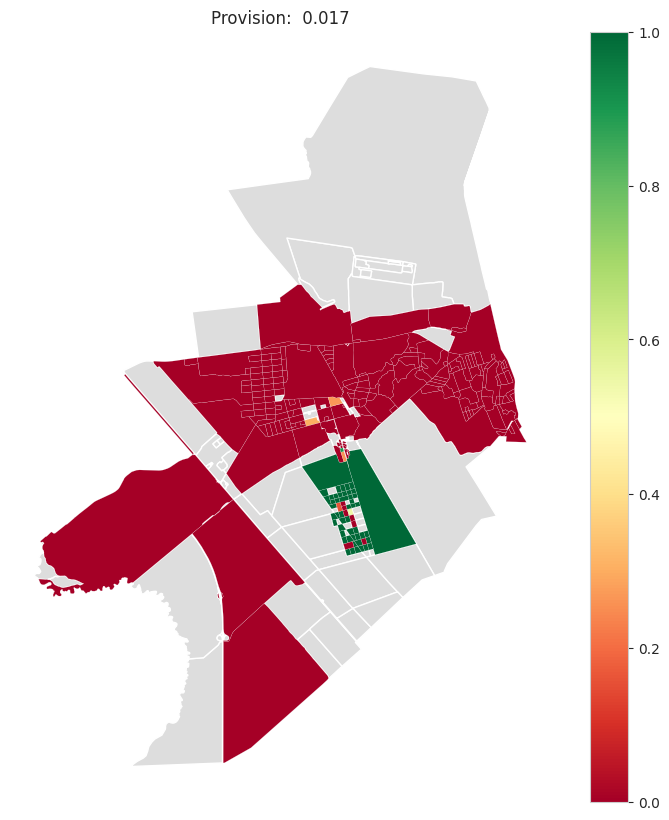

In [67]:
from blocksnet import Provision, ProvisionMethod
service_type = 'supermarket'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)
prov.plot(prov_res)

-------

###Оценка центральности по транспортной связности и разнообразию сервисов в кварталах

In [56]:
from blocksnet import Centrality, PopulationCentrality

In [57]:
centrality = Centrality(city_model=city)
result_centrality = centrality.calculate()
result_centrality

geometry  connectivity  \
id                                                                     
0    POLYGON ((365578.066 6618818.811, 365585.179 6...      6.359375   
1    POLYGON ((365585.179 6618823.682, 365578.066 6...      5.199219   
2    POLYGON ((367700.433 6616376.542, 367698.837 6...      3.605469   
3    POLYGON ((367699.528 6616357.359, 367698.808 6...      3.531250   
4    POLYGON ((368477.180 6617657.195, 368413.340 6...      3.167969   
..                                                 ...           ...   
415  POLYGON ((370064.571 6616115.069, 370157.744 6...      3.226562   
416  POLYGON ((370157.744 6616139.801, 370253.091 6...      3.308594   
417  POLYGON ((370253.091 6616165.057, 370346.989 6...      3.292969   
418  POLYGON ((370346.989 6616189.955, 370445.864 6...      3.408203   
419  POLYGON ((370445.864 6616216.172, 370540.495 6...      3.347656   

      density  diversity  centrality  
id                                    
0         NaN        NaN         NaN  
1    0.000030       -0.0    0.172123  
2         NaN        NaN         NaN  
3         NaN        NaN         NaN  
4         NaN        NaN         NaN  
..        ...        ...         ...  
415  0.000098       -0.0    0.124536  
416       NaN        NaN         NaN  
417       NaN        NaN         NaN  
418       NaN        NaN         NaN  
419       NaN        NaN         NaN  

[420 rows x 5 columns]

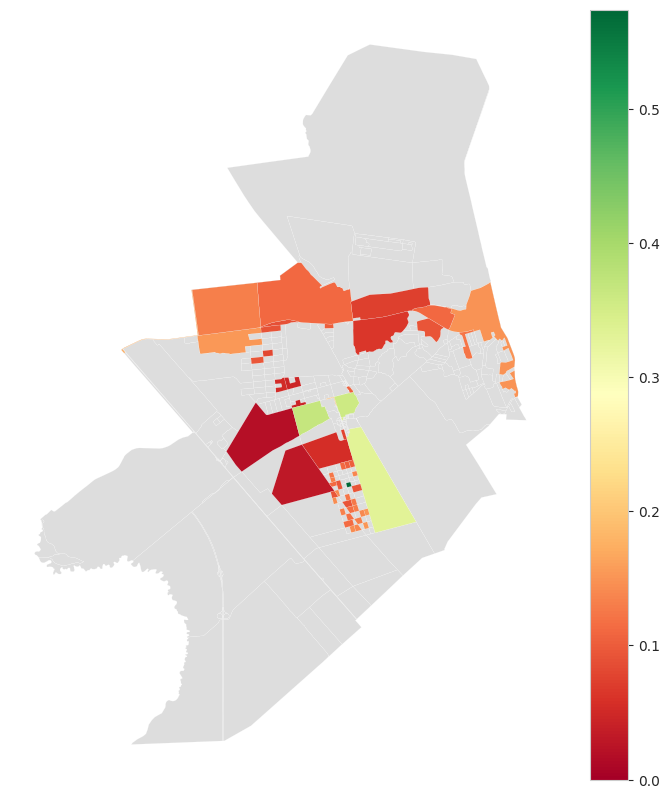

In [58]:
Centrality.plot(result_centrality, figsize =(10,10))

###Оценка центральности по транспортной связности и населению в квартала

In [59]:
centrality_population = PopulationCentrality(city_model=city)
result_centrlity_population = centrality_population.calculate()
result_centrlity_population

geometry  population_centrality
id                                                                           
0    POLYGON ((365578.066 6618818.811, 365585.179 6...                   0.06
1    POLYGON ((365585.179 6618823.682, 365578.066 6...                    NaN
2    POLYGON ((367700.433 6616376.542, 367698.837 6...                   1.65
3    POLYGON ((367699.528 6616357.359, 367698.808 6...                   1.53
4    POLYGON ((368477.180 6617657.195, 368413.340 6...                   3.31
..                                                 ...                    ...
415  POLYGON ((370064.571 6616115.069, 370157.744 6...                   3.51
416  POLYGON ((370157.744 6616139.801, 370253.091 6...                   3.73
417  POLYGON ((370253.091 6616165.057, 370346.989 6...                   3.85
418  POLYGON ((370346.989 6616189.955, 370445.864 6...                   4.02
419  POLYGON ((370445.864 6616216.172, 370540.495 6...                   4.02

[426 rows x 2 columns]

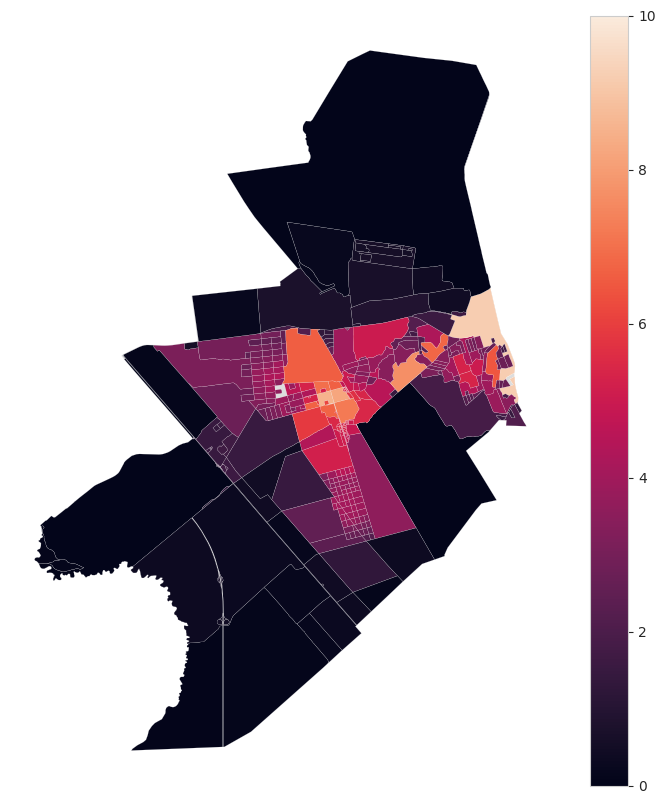

In [60]:
PopulationCentrality.plot(result_centrlity_population, figsize =(10,10))

-----------------------

### Доступность

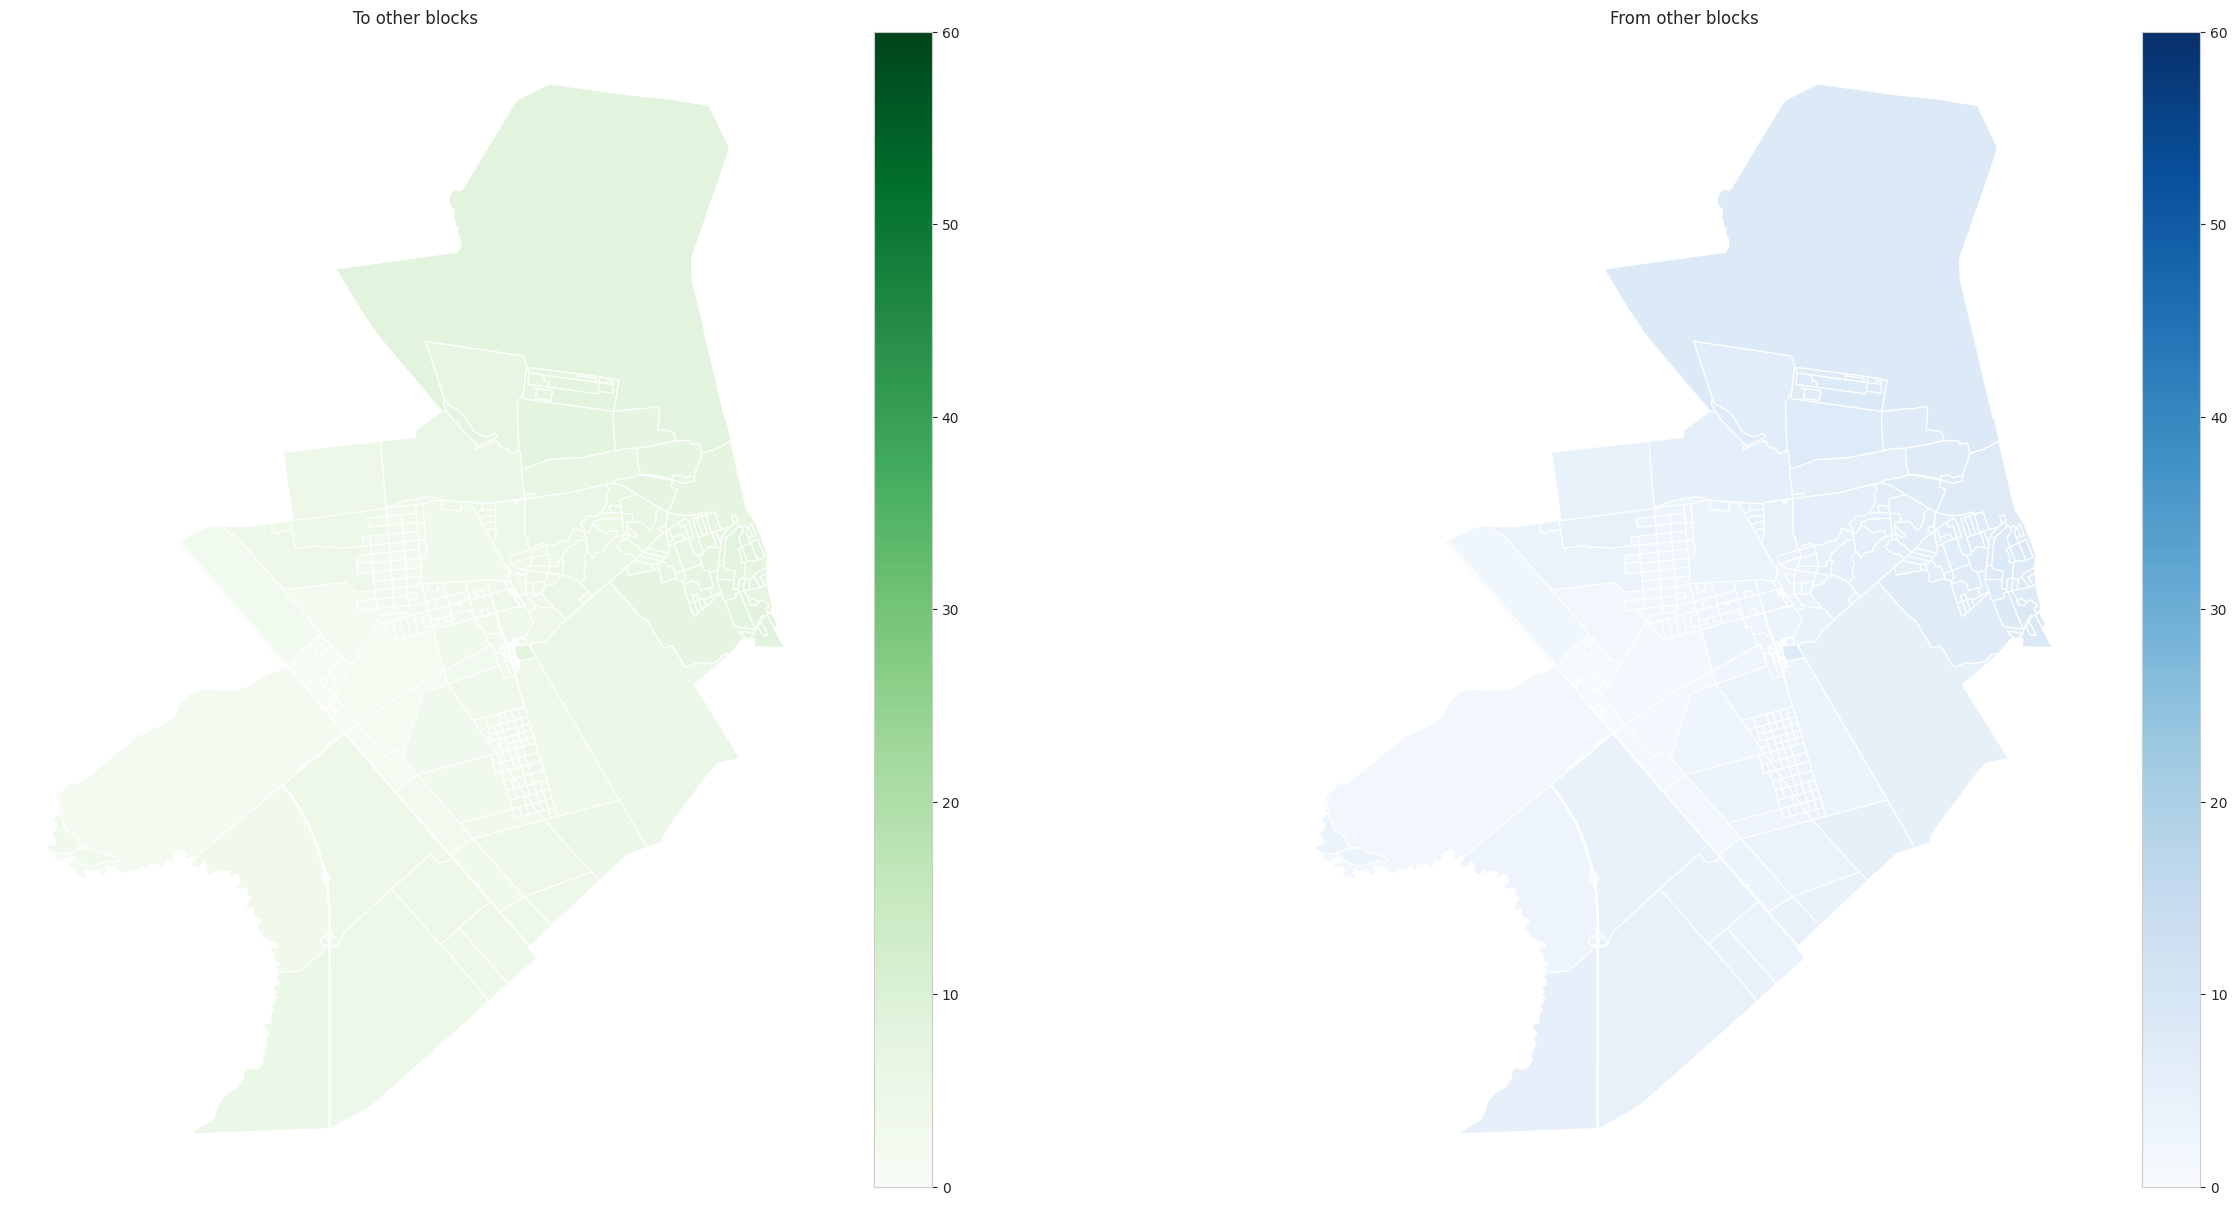

In [68]:
from blocksnet import Accessibility, Connectivity
accessibility = Accessibility(city_model=city)
block = city[2] # квартал от которого будем считать доступность
result = accessibility.calculate(block)

Accessibility.plot(result, linewidth=0.9, figsize=(30,15))

In [69]:
city.to_pickle(os.path.join(results_path,'city_model_scenario 1.pickle'))